<a href="https://colab.research.google.com/github/torrhen/pytorch/blob/main/08_pytorch_paper_replicating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  import torch
  import torchvision
  # check torch 0.12+
  assert(torch.__version__.split('.')[1] >= 12)
  # check torchvision 0.13+
  assert(torchvision.__version__.split('.') >= 13)
  print(f"torch version: {torch.__version__}")
  print(f"torchvision version: {torchvision.__version__}")
except:
  # install latest torch and torchvision
  !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
  import torch
  import torchvision
  print(f"torch version: {torch.__version__}")
  print(f"torchvision version: {torchvision.__version__}")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
torch version: 1.13.1+cu116
torchvision version: 0.14.1+cu116


In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# import torchinfo or download if necessary
try:
  from torchinfo import summary
except:
  !pip install -q torchinfo
  from torchinfo import summary

# import third party scripts or download from repo if necessary
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    # clone repo
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    # move files from repo to current directory
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    # remove repo -r=recursive, -f=force
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3416, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 3416 (delta 47), reused 92 (delta 39), pack-reused 3302
Receiving objects: 100% (3416/3416), 643.45 MiB | 17.36 MiB/s, done.
Resolving deltas: 100% (1954/1954), done.
Updating files: 100% (222/222), done.


In [3]:
# device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
# download third party data and extract to data/pizza_steak_sushi
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip", destination="pizza_steak_sushi")

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


In [5]:
# store file paths for training and test image folders
train_folder = image_path / "train"
test_folder = image_path / "test"

In [6]:
# transform to resize images to 224 x 224 for ViT and convert to tensor
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]
)

In [7]:
import os

# create data loaders
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_folder,
                                                                           test_dir=test_folder,
                                                                           transform=transform,
                                                                           batch_size=BATCH_SIZE,
                                                                           num_workers=os.cpu_count())

image shape: torch.Size([3, 224, 224])


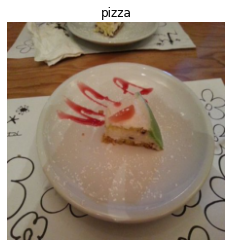

In [8]:
# get next batch of images and labels
batch_images, batch_labels = next(iter(train_dataloader))
# get first image and label from batch
image, label = batch_images[0], batch_labels[0]

# display image and label
print(f"image shape: {image.shape}")
# move color channel for matplotlib
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False); # semicolon used to supress output in notebooks

### Patch embeddings

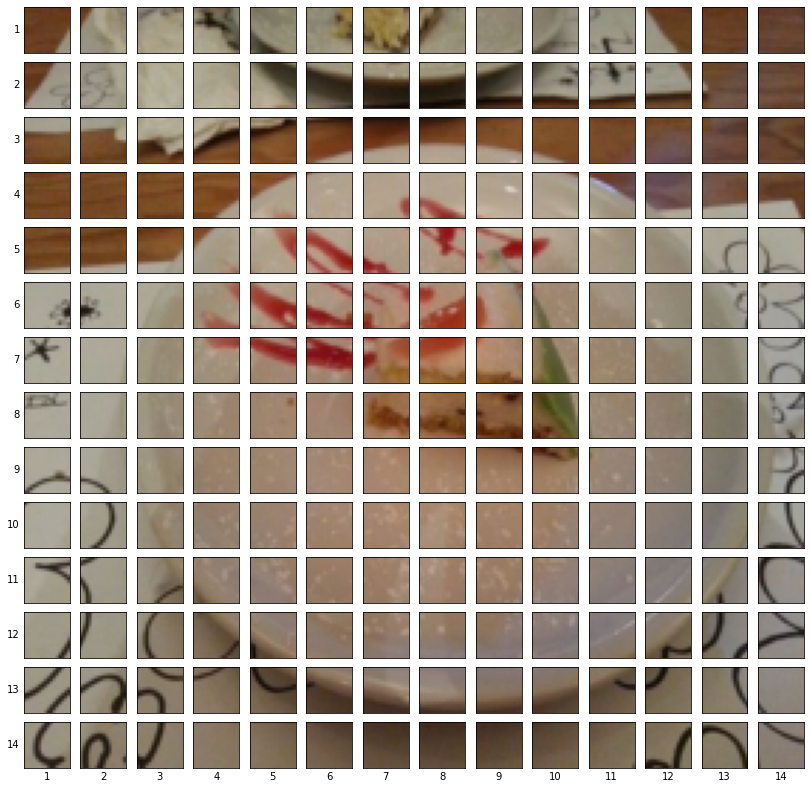

In [9]:
# split image into 16x16 patches

# move color channel for matplotlib
matplot_image = image.permute(1, 2, 0)

# dimensions of image
img_width = 224
img_height = 224
# size of patches
patch_size = 16
# number of patches in width or heght of image
num_patches = 224 / 16
assert(img_width % patch_size == 0)

# subplot for plotting every patch in image
fig, ax = plt.subplots(nrows=img_height // patch_size, ncols=img_width // patch_size, figsize=(num_patches, num_patches), sharex=True, sharey=True)

# for each patch in the height of the image
for i, row_patch in  enumerate(range(0, img_height, patch_size)):
  # for each patch in the row of the image
  for j, col_patch in enumerate(range(0, img_width, patch_size)):
    # add the current patch of the image to the subplot
    ax[i,j].imshow(matplot_image[row_patch:row_patch+patch_size, col_patch:col_patch+patch_size, :])
    # set the position of axes labels
    ax[i, j].set_ylabel(i+1, rotation="horizontal", horizontalalignment="right", verticalalignment="center") 
    ax[i, j].set_xlabel(j+1) 
    ax[i, j].set_xticks([])
    ax[i, j].set_yticks([])
    # only show labels on the first column and last row of subplots
    ax[i, j].label_outer()

### Convolution layer

convolution output: torch.Size([1, 768, 14, 14])


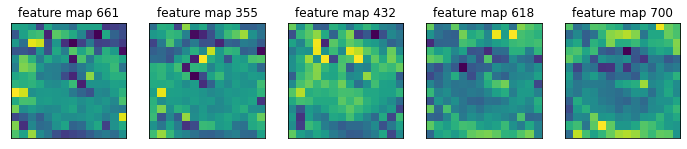

In [10]:
import random

# define convolution layer
layer_1 = nn.Conv2d(in_channels=3, out_channels=768, kernel_size=(patch_size, patch_size), stride=patch_size, padding=0)
# convolve image
feature_map_tensor = layer_1(image.unsqueeze(dim=0))
# convolution output shape
print(f"convolution output: {feature_map_tensor.shape}")

# display 5 random feature maps
rand_idx = random.sample(range(0, 768), k=5)

# set up figure to show the five feature maps
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

for i, idx in enumerate(rand_idx):
  # display the random feature map from the convolution output
  feature_map = feature_map_tensor[:, idx, :, :]
  ax[i].imshow(feature_map.squeeze().detach().numpy())
  ax[i].set_title(f"feature map {idx}")
  ax[i].set_xticks([])
  ax[i].set_yticks([])


torch.Size([1, 196, 768])


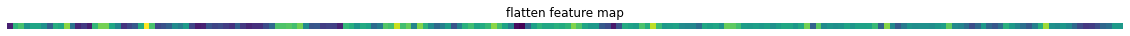

In [11]:
# flatten feature maps
layer_2 = nn.Flatten(start_dim=2, end_dim=3)
feature_map_tensor = layer_2(feature_map_tensor)
# move the feature map dimension
feature_map_tensor = feature_map_tensor.permute(0, 2, 1)

print(feature_map_tensor.shape)

plt.figure(figsize=(20,20))
plt.imshow(feature_map_tensor.detach().numpy()[:, :, 0])
plt.title(f"flatten feature map")
plt.axis(False);

In [12]:
# create custom patch embedding layer
class PatchEmbedding(nn.Module):
  def __init__(self, in_channels=3, embedding_size=768, patch_size=16):
    super(PatchEmbedding, self).__init__()
    self.in_channels = in_channels
    self.embedding_size = embedding_size
    self.patch_size = patch_size
    self.embedding = nn.Sequential(
        nn.Conv2d(in_channels=self.in_channels, out_channels=self.embedding_size, kernel_size=self.patch_size, stride=self.patch_size, padding=0),
        nn.Flatten(start_dim=2, end_dim=3)
    )

  def forward(self, x):
    # check dimension of input
    assert(x.shape[-1] % self.patch_size == 0)
    # convole input and flatten
    output = self.embedding(x)
    # swap embedding and patch dimensions
    return output.permute(0, 2, 1)

In [13]:
# apply patch embedding layer
embedding_layer = PatchEmbedding()
output = embedding_layer(image.unsqueeze(dim=0))

### Class Token

In [14]:
print(output)
print(output.shape)

tensor([[[-0.2313, -0.0829, -0.1658,  ...,  0.2491, -0.2807,  0.2070],
         [-0.5604, -0.2832, -0.5219,  ...,  0.4613, -0.6091,  0.3557],
         [-0.5997, -0.3866, -0.4273,  ...,  0.5223, -0.6171,  0.2662],
         ...,
         [-0.3603, -0.2081, -0.3299,  ...,  0.3087, -0.4298,  0.1455],
         [-0.3516, -0.1740, -0.2560,  ...,  0.5200, -0.3818,  0.2563],
         [-0.4653, -0.2969, -0.3048,  ...,  0.4234, -0.4886,  0.2706]]],
       grad_fn=<PermuteBackward0>)
torch.Size([1, 196, 768])


In [15]:
# create a class token with shape D (768) and append it to the num_pathes dimension (196)
# output shape [1, 196, 768] -> [1, 197, 768]

In [16]:
# [batch_size, num_tokens, embedding_dim]
# ensure class token is a learnable parameter that will be optimized
class_token = nn.Parameter(torch.ones(1, 1, 768)) # change to randn for best performance
print(class_token)
print(class_token.shape)

Parameter containing:
tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 

In [17]:
class_token_output = torch.cat((class_token, output), dim=1)
print(class_token_output)
print(class_token_output.shape)

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.2313, -0.0829, -0.1658,  ...,  0.2491, -0.2807,  0.2070],
         [-0.5604, -0.2832, -0.5219,  ...,  0.4613, -0.6091,  0.3557],
         ...,
         [-0.3603, -0.2081, -0.3299,  ...,  0.3087, -0.4298,  0.1455],
         [-0.3516, -0.1740, -0.2560,  ...,  0.5200, -0.3818,  0.2563],
         [-0.4653, -0.2969, -0.3048,  ...,  0.4234, -0.4886,  0.2706]]],
       grad_fn=<CatBackward0>)
torch.Size([1, 197, 768])


### Position Embedding

In [18]:
# create learnable embedding with size [batch_size, N+1, D]
num_patches = 224 * 224 // patch_size**2
position_embedding = nn.Parameter(torch.ones(1, num_patches+1, 768)) # change to randn for best performance

# add the positional embedding to the class_token/patch embedding
position_embedding_output = class_token_output + position_embedding
# all values should have increased by each value specified by the position embedding
print(position_embedding_output)
print(position_embedding_output.shape)

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.7687, 0.9171, 0.8342,  ..., 1.2491, 0.7193, 1.2070],
         [0.4396, 0.7168, 0.4781,  ..., 1.4613, 0.3909, 1.3557],
         ...,
         [0.6397, 0.7919, 0.6701,  ..., 1.3087, 0.5702, 1.1455],
         [0.6484, 0.8260, 0.7440,  ..., 1.5200, 0.6182, 1.2563],
         [0.5347, 0.7031, 0.6952,  ..., 1.4234, 0.5114, 1.2706]]],
       grad_fn=<AddBackward0>)
torch.Size([1, 197, 768])


### Multi-Head Self Attention and Layer Normalisation

In [19]:
# custom multi-head self attention layer
class MultiHeadSelfAttentionBlock(nn.Module):
  def __init__(self, embedding_dim=768, num_heads=12, attn_dropout=0):
    super(MultiHeadSelfAttentionBlock, self).__init__()
    self.embedding_dim = embedding_dim
    self.num_heads = num_heads
    self.attn_dropout = attn_dropout
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
    self.multihead_attn = nn.MultiheadAttention(embed_dim=self.embedding_dim,
                                     num_heads=self.num_heads,
                                     dropout=self.attn_dropout,
                                     batch_first=True)
    
  def forward(self, x):
    # layer normalization
    x = self.layer_norm(x)
    output, _ = self.multihead_attn(query=x, # query embedding
                         key = x, # key embedding
                         value = x, # value embedding
                         need_weights=False)
    return output

In [30]:
MSA = MultiHeadSelfAttentionBlock()

print(position_embedding_output, position_embedding_output.shape)
msa_output = MSA(position_embedding_output)
print(msa_output, msa_output.shape)


tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.7687, 0.9171, 0.8342,  ..., 1.2491, 0.7193, 1.2070],
         [0.4396, 0.7168, 0.4781,  ..., 1.4613, 0.3909, 1.3557],
         ...,
         [0.6397, 0.7919, 0.6701,  ..., 1.3087, 0.5702, 1.1455],
         [0.6484, 0.8260, 0.7440,  ..., 1.5200, 0.6182, 1.2563],
         [0.5347, 0.7031, 0.6952,  ..., 1.4234, 0.5114, 1.2706]]],
       grad_fn=<AddBackward0>) torch.Size([1, 197, 768])
tensor([[[-0.3116, -0.0230,  0.2571,  ...,  0.4715, -0.1981, -0.1084],
         [-0.3081, -0.0240,  0.2556,  ...,  0.4645, -0.1968, -0.1123],
         [-0.3072, -0.0238,  0.2553,  ...,  0.4662, -0.1970, -0.1135],
         ...,
         [-0.3082, -0.0246,  0.2570,  ...,  0.4669, -0.1985, -0.1134],
         [-0.3082, -0.0233,  0.2568,  ...,  0.4678, -0.1974, -0.1142],
         [-0.3080, -0.0233,  0.2553,  ...,  0.4669, -0.1969, -0.1136]]],
       grad_fn=<TransposeBackward0>) torch.Size([1, 197, 768])


### MLP Layer

In [36]:
class MLPBlock(nn.Module):
  def __init__(self, embedding_dim=768, hidden_dim=3072, dropout=0.1):
    super(MLPBlock, self).__init__()
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim, out_features=hidden_dim),
        # Gaussian Error Linear Units
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=hidden_dim, out_features=embedding_dim),
        nn.Dropout(p=dropout)
    )

  def forward(self, x):
    # layer normalization
    x = self.layer_norm(x)
    # MLP block
    output = self.mlp(x)
    return output


In [38]:
# instantiate multi layer perceptron
mlp_block = MLPBlock()

print(msa_output, msa_output.shape)
# pass output of multi head self attention block to MLP
mlp_output = mlp_block(msa_output)
print(mlp_output, mlp_output.shape)

tensor([[[-0.3116, -0.0230,  0.2571,  ...,  0.4715, -0.1981, -0.1084],
         [-0.3081, -0.0240,  0.2556,  ...,  0.4645, -0.1968, -0.1123],
         [-0.3072, -0.0238,  0.2553,  ...,  0.4662, -0.1970, -0.1135],
         ...,
         [-0.3082, -0.0246,  0.2570,  ...,  0.4669, -0.1985, -0.1134],
         [-0.3082, -0.0233,  0.2568,  ...,  0.4678, -0.1974, -0.1142],
         [-0.3080, -0.0233,  0.2553,  ...,  0.4669, -0.1969, -0.1136]]],
       grad_fn=<TransposeBackward0>) torch.Size([1, 197, 768])
tensor([[[-0.0977,  0.0855,  0.0124,  ..., -0.3514,  0.1074, -0.2779],
         [ 0.1035, -0.0241, -0.0945,  ..., -0.3304,  0.2145, -0.3529],
         [-0.0239,  0.0209, -0.1197,  ..., -0.1958,  0.1595, -0.1298],
         ...,
         [-0.0000, -0.0616,  0.0279,  ..., -0.2939,  0.1899, -0.1460],
         [-0.0380,  0.1300, -0.0809,  ..., -0.1866,  0.0309, -0.1520],
         [-0.0396,  0.0378,  0.0285,  ..., -0.3277,  0.1371, -0.1515]]],
       grad_fn=<MulBackward0>) torch.Size([1, 197, 76